# 테마주 지수 만들기

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

In [6]:
import requests
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import time

In [7]:
import FinanceDataReader as fdr

stocklst = fdr.StockListing('KRX')  # stocklst = 한국 전체 주식
stocklst.head()

,Symbol,Market,Name,Sector,Industry,ListingDate,SettleMonth,Representative,HomePage,Region
0,060310,KOSDAQ,3S,전자부품 제조업,반도체 웨이퍼 캐리어,2002-04-23,03월,김세완,http://www.3sref.com,서울특별시
1,095570,KOSPI,AJ네트웍스,산업용 기계 및 장비 임대업,"렌탈(파렛트, OA장비, 건설장비)",2015-08-21,12월,박대현,http://www.ajnet.co.kr,서울특별시
2,006840,KOSPI,AK홀딩스,기타 금융업,지주사업,1999-08-11,12월,"채형석, 이석주(각자 대표이사)",http://www.aekyunggroup.co.kr,서울특별시
3,054620,KOSDAQ,APS홀딩스,기타 금융업,인터넷 트래픽 솔루션,2001-12-04,12월,정기로,http://www.apsholdings.co.kr,경기도
4,265520,KOSDAQ,AP시스템,특수 목적용 기계 제조업,디스플레이 제조 장비,2017-04-07,12월,김영주,http://www.apsystems.co.kr,경기도


# 테마주 지수구하기

## 사료,사료첨가제  주(df_index1)

In [41]:
# 지수 구하기 
driver = webdriver.Chrome()

company_lst = [
# 사료,사료첨가제
# '이지바이오', #- 사료, 사료첨가제 2016년 상장 안됨
'진바이오텍', 
# '체리부로', #- 육계,사료 싱징2017년
'우성', #- 배합사료
'한일사료' #- 배합사료 
]


codes_lst = stocklst[stocklst.Name.apply(lambda stock: stock in company_lst)].Symbol.to_list()  #Symbol = 코드
# print(len(codes_lst)) # codes 의 길이가 company lst 의 길이가 같아야 정상적으로 나온거임 
# codes_lst

marketcap = dict()

for code in codes_lst:
    print(code)
    df_p = fdr.DataReader(code,'2016-01-01', '2018-12-31')
        
    #기준시점 시가 총액(시작날짜)
    price1 = df_p.loc['2016-01-04']['Close']
    
    url1 = 'https://navercomp.wisereport.co.kr/v2/company/c1010001.aspx?cmp_cd={}'.format(code)
    driver.get(url1)
    time.sleep(0.5)
    html1 = driver.page_source
    df1 = pd.read_html(html1)[1]
   
    # 발행 주식수
    outstanding = df1.iloc[6][1].split('/')[0]
    outstanding = outstanding.replace('주','') # 1,231,000주 -> 1,231,000
    outstanding = outstanding.replace(',', '') # 1,231,000 -> 1231000
    outstanding =  float(outstanding)
    print("발행 주식수: ",outstanding)
    
    # 유동비율 
    floating = df1.iloc[6][1].split('/')[1]
    floating = floating.replace('%', '')  # %기호 없애주기
    floating = float(floating)
    print("유동비율: ",floating)
    
     #액면가
    price_f = df1.iloc[2][1]
    price_f = price_f.replace('원', '') # 5,000원 -> 5,000
    price_f = price_f.replace(',', '') # 5,000 -> 5000
    price_f = int(price_f)
    print("액면가: ", price_f)
    print('-'* 50)
    
    ## 지수 구하기
    
    # 기업들의 주가 데이터프레임: df_p
#     df_p = fdr.DataReader(code,'2018-01-01', '2018-12-31')
    
    #비교시점의 시가총액(비교시점주가 * 발행주식수 * 유동비율)
    
    if price_f == 5000:     #액면금액이 5000원
        pass
    elif price_f == 2500:   #액면금액이 2500원
        df_p['Close'] = df_p['Close']/2
        
    elif price_f == 500:    #액면금액이 500원
        df_p['Close'] = df_p['Close']/10
        
    elif price_f == 100:    #액면금액이 100원
        df_p['Close'] = df_p['Close']/50
        
   # 회사코드 -> 회사명
    company_name = stocklst[stocklst['Symbol']== str(code)]['Name'].values[0]
    
    # 회사의 시가총액 계산
    marketcap[company_name] = df_p['Close'] * outstanding * floating   # 딕셔너리에 추가
   
 
df_index1 = pd.DataFrame(marketcap)
df_index1['total'] = df_index1.sum(axis=1)

# 기준시점 시가총액 ( 기준시점주가 * 발행주식수 * 유동비율)

marketcap_std = df_index1['total'].iloc[0]

# 지수 = (각기업시가총액합 / 2019년 1월2일의 각 기업시가총액합) * 100
df_index1['지수'] = (df_index1['total']/ marketcap_std) * 100

df_index1.reset_index(inplace=True)
df_index1.head()





    

006980
발행 주식수:  3090000.0
유동비율:  50.62
액면가:  5000
--------------------------------------------------
086060
발행 주식수:  8610587.0
유동비율:  70.14
액면가:  500
--------------------------------------------------
005860
발행 주식수:  39403685.0
유동비율:  51.56
액면가:  500
--------------------------------------------------


,Date,우성,진바이오텍,한일사료,total,지수
0,2016-01-04,6.444331e+12,2.714740e+11,4.349771e+11,7.150782e+12,100.000000
1,2016-01-05,6.592926e+12,2.681523e+11,4.301012e+11,7.291179e+12,101.963384
2,2016-01-06,6.194066e+12,2.868746e+11,4.000327e+11,6.880973e+12,96.226859
3,2016-01-07,6.280094e+12,2.898944e+11,3.866238e+11,6.956612e+12,97.284638
4,2016-01-08,6.225349e+12,2.914042e+11,3.923124e+11,6.909065e+12,96.619718


## 의료품,백신주 (df_index2)

In [42]:
driver = webdriver.Chrome()

company_lst = [
# 의료품 백신주
'제일바이오', #- 동물사료첨가제
# '에이프로젠제약', #- 의약품
'이글벳',   #- 동물의약품
'넥스트BT',   #- 조류바이러스 억제효능
'대성미생물', #- 조류독감 백신 개발 완료
'대한뉴팜', #- 조류독감 예방치료제
'중앙백신', #- 동물용백신'
'파루'  #- 소독
]

codes_lst = stocklst[stocklst.Name.apply(lambda stock: stock in company_lst)].Symbol.to_list()  #Symbol = 코드
# print(len(codes_lst)) # codes 의 길이가 company lst 의 길이가 같아야 정상적으로 나온거임 
# codes_lst

marketcap = dict()

for code in codes_lst:
    print(code)
    df_p = fdr.DataReader(code,'2016-01-01', '2018-12-31')
        
    #기준시점 시가 총액(시작날짜)
    price1 = df_p.loc['2016-01-04']['Close']
    
    url1 = 'https://navercomp.wisereport.co.kr/v2/company/c1010001.aspx?cmp_cd={}'.format(code)
    driver.get(url1)
    time.sleep(0.5)
    html1 = driver.page_source
    df1 = pd.read_html(html1)[1]
   
    # 발행 주식수
    outstanding = df1.iloc[6][1].split('/')[0]
    outstanding = outstanding.replace('주','') # 1,231,000주 -> 1,231,000
    outstanding = outstanding.replace(',', '') # 1,231,000 -> 1231000
    outstanding =  float(outstanding)
    print("발행 주식수: ",outstanding)
    
    # 유동비율 
    floating = df1.iloc[6][1].split('/')[1]
    floating = floating.replace('%', '')  # %기호 없애주기
    floating = float(floating)
    print("유동비율: ",floating)
    
     #액면가
    price_f = df1.iloc[2][1]
    price_f = price_f.replace('원', '') # 5,000원 -> 5,000
    price_f = price_f.replace(',', '') # 5,000 -> 5000
    price_f = int(price_f)
    print("액면가: ", price_f)
    print('-'* 50)
    
    ## 지수 구하기
    
    # 기업들의 주가 데이터프레임: df_p
#     df_p = fdr.DataReader(code,'2018-01-01', '2018-12-31')
    
    #비교시점의 시가총액(비교시점주가 * 발행주식수 * 유동비율)
    
    if price_f == 5000:     #액면금액이 5000원
        pass
    elif price_f == 2500:   #액면금액이 2500원
        df_p['Close'] = df_p['Close']/2
        
    elif price_f == 500:    #액면금액이 500원
        df_p['Close'] = df_p['Close']/10
        
    elif price_f == 100:    #액면금액이 100원
        df_p['Close'] = df_p['Close']/50
        
   # 회사코드 -> 회사명
    company_name = stocklst[stocklst['Symbol']== str(code)]['Name'].values[0]
    
    # 회사의 시가총액 계산
    marketcap[company_name] = df_p['Close'] * outstanding * floating   # 딕셔너리에 추가
   
 
df_index2 = pd.DataFrame(marketcap)
df_index2['total'] = df_index2.sum(axis=1)

# 기준시점 시가총액 ( 기준시점주가 * 발행주식수 * 유동비율)

marketcap_std = df_index2['total'].iloc[0]

# 지수 = (각기업시가총액합 / 2019년 1월2일의 각 기업시가총액합) * 100
df_index2['지수'] = (df_index2['total']/ marketcap_std) * 100

df_index2.reset_index(inplace=True)
df_index2.head()


065170
발행 주식수:  88970559.0
유동비율:  72.46
액면가:  500
--------------------------------------------------
036480
발행 주식수:  3800000.0
유동비율:  61.4
액면가:  500
--------------------------------------------------
054670
발행 주식수:  14354920.0
유동비율:  57.68
액면가:  500
--------------------------------------------------
044960
발행 주식수:  12641883.0
유동비율:  58.62
액면가:  500
--------------------------------------------------
052670
발행 주식수:  29129064.0
유동비율:  70.37
액면가:  500
--------------------------------------------------
072020
발행 주식수:  9960000.0
유동비율:  63.58
액면가:  500
--------------------------------------------------
043200
발행 주식수:  41804315.0
유동비율:  74.87
액면가:  500
--------------------------------------------------


,Date,넥스트BT,대성미생물,대한뉴팜,이글벳,제일바이오,중앙백신,파루,total,지수
0,2016-01-04,2.569052e+12,2.054849e+11,1.453126e+12,4.394528e+11,5.315163e+11,8.051860e+11,1.343661e+12,7.347480e+12,100.000000
1,2016-01-05,2.565829e+12,2.045516e+11,1.403446e+12,4.379707e+11,5.282366e+11,8.129118e+11,1.362441e+12,7.315387e+12,99.563211
2,2016-01-06,2.482021e+12,2.059516e+11,1.407586e+12,4.387118e+11,5.345910e+11,8.282999e+11,1.362441e+12,7.259602e+12,98.803972
3,2016-01-07,2.482021e+12,2.066515e+11,1.382746e+12,4.290779e+11,5.325412e+11,8.257035e+11,1.322691e+12,7.181432e+12,97.740077
4,2016-01-08,2.494914e+12,2.178742e+11,1.366186e+12,4.335243e+11,5.278267e+11,8.231705e+11,1.299843e+12,7.163339e+12,97.493831


## 대체식품 주

In [44]:
driver = webdriver.Chrome()

company_lst = [
# 대체식품 주
'동원수산', #- 원양어업
'신라에스지',# - 수산물도매
'CJ씨푸드' #- 수산물'
]

codes_lst = stocklst[stocklst.Name.apply(lambda stock: stock in company_lst)].Symbol.to_list()  #Symbol = 코드
# print(len(codes_lst)) # codes 의 길이가 company lst 의 길이가 같아야 정상적으로 나온거임 
# codes_lst

marketcap = dict()

for code in codes_lst:
    print(code)
    df_p = fdr.DataReader(code,'2016-01-01', '2018-12-31')
        
    #기준시점 시가 총액(시작날짜)
    price1 = df_p.loc['2016-01-04']['Close']
    
    url1 = 'https://navercomp.wisereport.co.kr/v2/company/c1010001.aspx?cmp_cd={}'.format(code)
    driver.get(url1)
    time.sleep(0.5)
    html1 = driver.page_source
    df1 = pd.read_html(html1)[1]
   
    # 발행 주식수
    outstanding = df1.iloc[6][1].split('/')[0]
    outstanding = outstanding.replace('주','') # 1,231,000주 -> 1,231,000
    outstanding = outstanding.replace(',', '') # 1,231,000 -> 1231000
    outstanding =  float(outstanding)
    print("발행 주식수: ",outstanding)
    
    # 유동비율 
    floating = df1.iloc[6][1].split('/')[1]
    floating = floating.replace('%', '')  # %기호 없애주기
    floating = float(floating)
    print("유동비율: ",floating)
    
     #액면가
    price_f = df1.iloc[2][1]
    price_f = price_f.replace('원', '') # 5,000원 -> 5,000
    price_f = price_f.replace(',', '') # 5,000 -> 5000
    price_f = int(price_f)
    print("액면가: ", price_f)
    print('-'* 50)
    
    ## 지수 구하기
    
    # 기업들의 주가 데이터프레임: df_p
#     df_p = fdr.DataReader(code,'2018-01-01', '2018-12-31')
    
    #비교시점의 시가총액(비교시점주가 * 발행주식수 * 유동비율)
    
    if price_f == 5000:     #액면금액이 5000원
        pass
    elif price_f == 2500:   #액면금액이 2500원
        df_p['Close'] = df_p['Close']/2
        
    elif price_f == 500:    #액면금액이 500원
        df_p['Close'] = df_p['Close']/10
        
    elif price_f == 100:    #액면금액이 100원
        df_p['Close'] = df_p['Close']/50
        
   # 회사코드 -> 회사명
    company_name = stocklst[stocklst['Symbol']== str(code)]['Name'].values[0]
    
    # 회사의 시가총액 계산
    marketcap[company_name] = df_p['Close'] * outstanding * floating   # 딕셔너리에 추가
   
 
df_index3 = pd.DataFrame(marketcap)
df_index3['total'] = df_index3.sum(axis=1)

# 기준시점 시가총액 ( 기준시점주가 * 발행주식수 * 유동비율)

marketcap_std = df_index3['total'].iloc[0]

# 지수 = (각기업시가총액합 / 2019년 1월2일의 각 기업시가총액합) * 100
df_index3['지수'] = (df_index3['total']/ marketcap_std) * 100

df_index3.reset_index(inplace=True)
df_index3.head()


011150
발행 주식수:  35930773.0
유동비율:  53.48
액면가:  500
--------------------------------------------------
030720
발행 주식수:  4653805.0
유동비율:  76.52
액면가:  5000
--------------------------------------------------
025870
발행 주식수:  4000000.0
유동비율:  41.75
액면가:  500
--------------------------------------------------


,Date,CJ씨푸드,동원수산,신라에스지,total,지수
0,2016-01-04,6.658267e+11,3.137322e+12,1.067130e+11,3.909861e+12,100.000000
1,2016-01-05,6.802385e+11,3.119516e+12,1.060450e+11,3.905800e+12,99.896118
2,2016-01-06,6.888856e+11,2.998439e+12,1.060450e+11,3.793370e+12,97.020569
3,2016-01-07,6.994543e+11,3.030489e+12,1.062120e+11,3.836155e+12,98.114866
4,2016-01-08,6.956111e+11,3.009122e+12,1.062120e+11,3.810946e+12,97.470093


# 시각화

## matplotlib

No handles with labels found to put in legend.


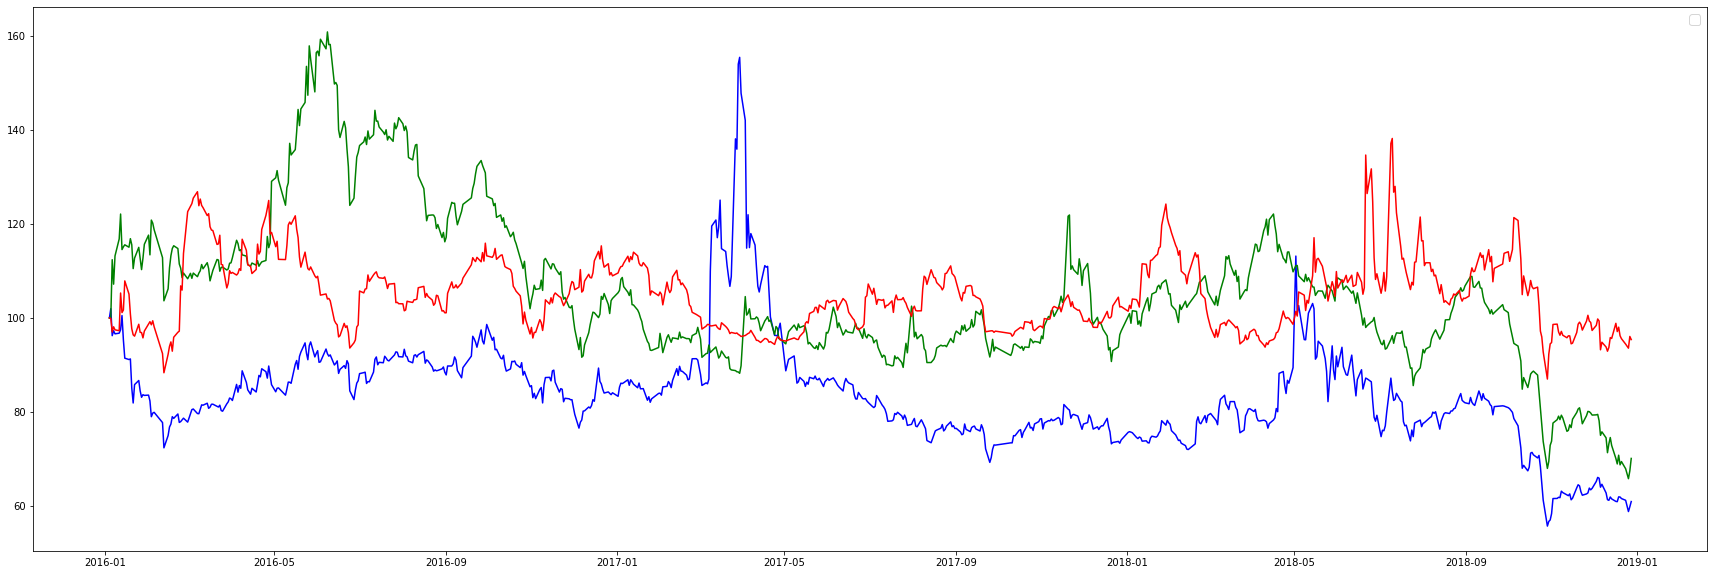

In [14]:
x = df_index1['Date']
y1 = df_index1['지수']
y2 = df_index2['지수']
y3 = df_index3['지수']
plt.figure(figsize=(30,10))
plt.legend(loc='best', ncol=2, fontsize=14)
plt.plot(x,y1,'b', x,y2,'g',x,y3,'r')
# plt.plot(x,y1,'b',label='폐기물주_지수', x,y2,'g',label='농약비료주_지수',x,y3,'r',label='제습기주_지수')


## plotly

In [17]:
# plotly
# 그래프 하나로 만들기
df_total = pd.DataFrame({'Date': df_index1['Date'], '사료주_지수':df_index1['지수'],'의료,백신주_지수':df_index2['지수'],'대체식품주_지수':df_index3['지수']})

fig = px.line(df_total, x='Date', y=['사료주_지수','의료,백신주_지수','대체식품주_지수'],title = 'ai 테마주 지수')
fig.update_xaxes(rangeslider_visible=True)
fig.show()                

In [47]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

df_index11 = df_index1.set_index('Date')
df_index22 = df_index2.set_index('Date')
df_index33 = df_index3.set_index('Date')

'사료주_지수','의료,백신주_지수','대체식품주_지수'

fig = make_subplots(
    rows=3, cols=2
    ,subplot_titles=("사료주_지수_2016-2017년", "사료주_지수_2017-2018년", \
                    "의료,백신주_지수_2016-2017년","의료,백신주_지수_2017-2018년",\
                    "대체식품주_지수_2016-2017년", "대체식품주_지수_2017-2018년"))

#("지수_폐기물주_2016년","지수_폐기물주_2017년","지수_제습기주_2016년",\
#지수_농약비료주_2016년","지수_농약비료주_2017년",지수_농약비료주_2017년",\
#지수_제습기주_2018년",지수_제습기주_2018년","지수_제습기주_2018년"))



fig.add_trace(go.Scatter(x= df_index11['2016-01':'2017-07'].index, y=df_index11['지수'].loc['2016-01':'2017-07']),
              row=1, col=1)

fig.add_trace(go.Scatter(x=df_index11['2017-10':'2018-04'].index, y=df_index11['지수'].loc['2017-10':'2018-04']),
              row=1, col=2)

# fig.add_trace(go.Scatter(x=df_index11['2016-06':'2016-08'].index, y=df_index33['지수'].loc['2016-06':'2016-08']),
#               row=3, col=3)



fig.add_trace(go.Scatter(x=df_index22['2016-01':'2017-07'].index, y=df_index22['지수'].loc['2016-01':'2017-07']),
              row=2, col=1)

fig.add_trace(go.Scatter(x=df_index22['2017-10':'2018-04'].index, y=df_index22['지수'].loc['2017-10':'2018-04']),
              row=2, col=2)


# fig.add_trace(go.Scatter(x=df_index33['2017-06':'2017-08'].index, y=df_index33['지수'].loc['2017-06':'2017-08']),
#               row=2, col=3)




fig.add_trace(go.Scatter(x=df_index33['2016-01':'2017-07'].index, y=df_index33['지수'].loc['2016-01':'2017-07']),
              row=3, col=1)

fig.add_trace(go.Scatter(x=df_index33['2017-10':'2018-04'].index, y=df_index33['지수'].loc['2017-10':'2018-04']),
              row=3, col=2)

# fig.add_trace(go.Scatter(x=df_index33['2018-06':'2018-08'].index, y=df_index33['지수'].loc['2018-06':'2018-08']),
#               row=3, col=3)


fig.add_vline(x ='2016-03-23')
fig.add_vline(x ='2017-06-21')

# fig.add_vline(x ='2017-11-17')
# fig.add_vline(x ='2018-03-17')


fig.update_layout(height=1200, width=2000,
                  title_text="ai 테마주 추세")

# fig.show()

In [81]:
pd.Series(np.arange(0,200,1))

0        0
1        1
2        2
3        3
4        4
      ... 
195    195
196    196
197    197
198    198
199    199
Length: 200, dtype: int32

In [40]:
df_index1['Date'][100:165]  # 0:248 2015년

100   2015-06-01
101   2015-06-02
102   2015-06-03
103   2015-06-04
104   2015-06-05
         ...    
160   2015-08-25
161   2015-08-26
162   2015-08-27
163   2015-08-28
164   2015-08-31
Name: Date, Length: 65, dtype: datetime64[ns]

In [20]:
df_index1['Date'][348:411]  #248:494 2016년

348   2016-06-01
349   2016-06-02
350   2016-06-03
351   2016-06-07
352   2016-06-08
         ...    
406   2016-08-24
407   2016-08-25
408   2016-08-26
409   2016-08-29
410   2016-08-30
Name: Date, Length: 63, dtype: datetime64[ns]

In [26]:
df_index3['Date'][595:659] # 495: 끝 2017년

595   2017-06-01
596   2017-06-02
597   2017-06-05
598   2017-06-07
599   2017-06-08
         ...    
654   2017-08-25
655   2017-08-28
656   2017-08-29
657   2017-08-30
658   2017-08-31
Name: Date, Length: 64, dtype: datetime64[ns]

## 개별 주식의 추세

In [12]:

stocklst = fdr.StockListing('KRX')
company_lst = [
# 장마 테마주
# (1) 폐기물: 2011년 7월 27일 부근 변동성 큰 주식
'KG ETS',
'인선이엔티',
'와이엔텍',
'코엔텍',
'스페코'

]
codes_lst = stocklst[stocklst.Name.apply(lambda stock: stock in company_lst)].Symbol.to_list() 


price_history = dict()

for code in codes_lst:
    df = fdr.DataReader(code,'2016-01-01', '2018-12-31')
    price_history[code]= df['Close']   # 회사코드: [과거주가 리스트] 
    company_name = stocklst[stocklst['Symbol']== str(code)]['Name'].values[0]
    print('회사이름: ',company_name , '회사코드: ',str(code) )
        
df_p = pd.DataFrame(price_history)
df_p.reset_index(inplace=True)

# 코드 문자열로 바꿔주기
code_str = list(map(str,codes_lst))

fig = px.line(df_p, x='Date', y= code_str)
fig.update_xaxes(rangeslider_visible=True)
fig.show()

회사이름:  KG ETS 회사코드:  151860
회사이름:  스페코 회사코드:  013810
회사이름:  와이엔텍 회사코드:  067900
회사이름:  인선이엔티 회사코드:  060150
회사이름:  코엔텍 회사코드:  029960


In [13]:
#주가 딕셔너리에 넣기-> 유가,개별 주식간 비교에 사용

stocklst = fdr.StockListing('KRX')
company_lst = [
# 장마 테마주
# (2) 농약비료
'경농' ,
# '조비' ,
'동방아그로',
# '남해화학'
]
codes_lst = stocklst[stocklst.Name.apply(lambda stock: stock in company_lst)].Symbol.to_list() 


price_history = dict()

for code in codes_lst:
    df = fdr.DataReader(code,'2011-01-01', '2011-12-31')
    price_history[code]= df['Close']   # 회사코드: [과거주가 리스트] 
    company_name = stocklst[stocklst['Symbol']== str(code)]['Name'].values[0]
    print('회사이름: ',company_name , '회사코드: ',str(code) )
        
df_p = pd.DataFrame(price_history)
df_p.reset_index(inplace=True)

# 코드 문자열로 바꿔주기
code_str = list(map(str,codes_lst))

fig = px.line(df_p, x='Date', y= code_str)
fig.update_xaxes(rangeslider_visible=True)
fig.show()

회사이름:  경농 회사코드:  002100
회사이름:  동방아그로 회사코드:  007590


In [14]:
'KG ETS',
'인선이엔티',

=장마
- 폐기물 관련주
'KG ETS'
'인선이엔티'
'와이엔텍' 
# '제넨바이오' *
# '코엔텍'
# '그린플러스' *
'스페코'
'태영건설'

 - 농약/비료
'경농' *
'조비' 
'동방아그로' *
'남해화학'
백광소재
효성오앤비

- 제습기
위닉스
신일전자
파세코
코웨이


남해화학 동방아그로 조비 
파루 경농



= 가뭄
뉴보텍 - 상하수관 및 하수정비

동양철관 - 수도관 및 배관용 장비 제조 및 판매

뉴로스 - 상하수도 및 수처리

자연과환경 - 4대강 관련주

CSA코믹스 - 수처리

웰크론한텍 - 폐수처리 및 담수처리 전문업체


열대야 테마주 
'신일전자'
'파세코'
'에스씨디'
'빙그레'
'위닉스'
'태경케미컬'
'위니아딤채'
'에스피지'
'롯데하이마트'
'비엠티'

SyntaxError: invalid syntax (Temp/ipykernel_15532/1647323608.py, line 4)

## 코스피, 코스닥 지수

In [ ]:
# df_index = fdr.DataReader('KS100','2019-01-01','2019-12-31') 왜 안될까

## 다음날 아침 급등주 캐치 전략

In [ ]:
df.head()

In [ ]:
# 전날 종가 다음날 고가 변동률

diff_history = dict()

for code in codes_fire:
    df = fdr.DataReader(code,'2019-01-02', '2019-12-31')
    diff_history[code]= df['Change']   # 회사코드: [과거주가 리스트] 

df_diff = pd.DataFrame(diff_history)
df_diff

In [ ]:
# 구제역 관련주
# 대체식품(수산업,닭)
: 한성기업,정다운,동우팜투테이블,사조오양, 
신라교역, 마니커, 동원산업 
신라에스지 
하림 
동원수산 
이지홀딩스
팜스토리


# 사료
한일사료

# 백신
우성사료 우진비앤지 대성미생물 

# 석회
태경비케이 



In [ ]:
# ai 관련주(주로 백신) : ai가 길어지면 대체식품주 오를 수 있음

파루
제일바이오
이글벳
진원생명과학
팜스웰바이오
씨티씨바이오
대한뉴팜

